<a href="https://colab.research.google.com/github/sgr1118/EX/blob/main/%5BExp_10%5D_Create_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10-10. 프로젝트 : 단어 Level로 번역기 업그레이드하기

- 동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성

- 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다.

- 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플

- 33000개 중 3000개는 테스트 데이터로 분리하여 사용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# 영구적인 라이브러리 설치하기위한 경로 지정
import os, sys

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/MyDrive/Colab Notebooks/my_env2', my_path)
sys.path.insert(0, my_path)

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip install --target=$my_path--upgrade tensorflow

In [2]:
# 필요한 라이브러리 불러오기
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [3]:
# 데이터 불러오기
file_path = '/content/drive/MyDrive/Aiffel/EX/EX10_txt/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep = '\t')
print('전체 샘플의 수 :', len(lines))
lines.sample(3)

전체 샘플의 수 : 194513


,eng,fra,cc
142688,Are you telling me how to do my job?,Es-tu en train de me dire comment faire mon bo...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
151465,Do you regularly experience dry mouth?,Avez-vous régulièrement la bouche sèche ?,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
64882,Jump as high as you can.,Saute le plus haut que tu peux.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [4]:
# train 데이터는 조간에 따라 33000개만 사용
lines = lines[['eng', 'fra']][:33000]
lines_c = lines.copy()
# 분석에 문제가 생길경우를 대비라여 copy파일 생성
lines_c.sample(5)

,eng,fra
12812,You're invited.,Vous êtes invitée.
15928,This is so hard.,C'est si dur.
13580,He is a student.,C'est un étudiant.
28407,Don't ask me again.,Ne me repose pas la question !
26039,They'll eat those.,Ils mangeront ceux-là.


# Step2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.
- 원래는 2단계이지만 미리 토큰을 삽입하고 전처리를 수행

In [5]:
# 시작 토큰<sos>와 종료 토큰<eos>만들기
sos_token = '<sos>' # tap키
eos_token = '<eos>' # 줄바꿈
lines_c.fra = lines_c.fra.apply(lambda x: '<sos> ' + x + ' <eos>')
print('전체 샘플의 수:', len(lines))
lines_c.sample(3)

전체 샘플의 수: 33000


,eng,fra
30504,Is breakfast ready?,<sos> Le petit-déjeuner est-il prêt ? <eos>
22248,You're too tense.,<sos> Vous êtes trop tendus. <eos>
18879,I really need it.,<sos> J'en ai vraiment besoin. <eos>


In [6]:
lines_c.iloc[:5]
# 다음 전처리에서 주의해야할 부문은 구두점의 띄어쓰기인것으로 판단된다.
# fra에서 어떤 구두점은 띄어쓰기가 되어있고 아닌것도 있다.

,eng,fra
0,Go.,<sos> Va ! <eos>
1,Go.,<sos> Marche. <eos>
2,Go.,<sos> Bouge ! <eos>
3,Hi.,<sos> Salut ! <eos>
4,Hi.,<sos> Salut. <eos>


# Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [7]:
# 문장 전처리 시작

# 전처리 기준
# 구두점(Punctuation)을 단어와 분리해주세요.
lines_c['eng'] = lines_c['eng'].str.replace(pat=r'([?.!,¿])', repl=r' \1', regex=True)
lines_c['fra'] = lines_c['fra'].str.replace(pat=r'([?.!,¿])', repl=r' \1', regex=True)

# 소문자로 바꿔주세요.
lines_c['eng'] = lines_c['eng'].str.lower()
lines_c['fra'] = lines_c['fra'].str.lower()

# 띄어쓰기 단위로 토큰를 수행하세요.
lines_c['eng'] = lines_c['eng'].str.split()
lines_c['fra'] = lines_c['fra'].str.split()

In [ ]:
lines_c

,eng,fra
0,"[go, .]","[<sos>, va, !, <eos>]"
1,"[go, .]","[<sos>, marche, ., <eos>]"
2,"[go, .]","[<sos>, bouge, !, <eos>]"
3,"[hi, .]","[<sos>, salut, !, <eos>]"
4,"[hi, .]","[<sos>, salut, ., <eos>]"
...,...,...
32995,"[what, did, tom, steal, ?]","[<sos>, qu'est-ce, que, tom, a, volé, ?, <eos>]"
32996,"[what, did, tom, write, ?]","[<sos>, qu'est-ce, que, tom, a, écrit, ?, <eos>]"
32997,"[what, did, they, want, ?]","[<sos>, que, voulaient-ils, ?, <eos>]"
32998,"[what, did, they, want, ?]","[<sos>, que, voulaient-elles, ?, <eos>]"


In [9]:
# 특정행을 추출하여 전처리 결과 확인
lines_c.iloc[22248]
# 토큰화 전 : 'he is a good boy !'
# 토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']
# 예시에 맞게 전처리가 잘 수행되었다.

eng                        [you're, too, tense, .]
fra    [<sos>, vous, êtes, trop, tendus, ., <eos>]
Name: 22248, dtype: object

# Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

- [위키독스](https://wikidocs.net/31766)

- 토크나이저는 이 문서를 참고하여 진행하였습니다.
- 영어, 프랑스어 전부 토크나이저를 각각 생성한다.
- 임베딩 층에 사용 할 단어장, 인코더, 디코더, 패딩, validation data 준비

In [ ]:
# tokenizer.texts_to_sequences()를 사용한 정수 시퀀스 변환 - 영어

eng_tokenizer = Tokenizer(char_level=False) # 단어 단위로 Tokenizer를 생성합니다.
eng_tokenizer.fit_on_texts(lines_c.eng) # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines_c.eng) # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[26, 1], [26, 1], [26, 1]]

In [ ]:
# tokenizer.texts_to_sequences()를 사용한 정수 시퀀스 변환 - 불어

fra_tokenizer = Tokenizer(char_level=True)   # 단어 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines_c.fra)        # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines_c.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 63, 7, 2], [1, 360, 3, 2], [1, 710, 7, 2]]

In [ ]:
# 단어장의 크기를 변수로 저장 0번 토큰을 고려하려 +1을 하고 저장
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4810
프랑스어 단어장의 크기 : 9990


In [ ]:
# 각 단어 데이터의 최대 길이 구하기
# 패딩을 하기 위한 작업

max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

# 시퀀스 길이 차이가 약 2배이다.

영어 시퀀스의 최대 길이 7
프랑스어 시퀀스의 최대 길이 15


In [ ]:
print('전체 샘플의 수 :',len(lines_c))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4810
프랑스어 단어장의 크기 : 9990
영어 시퀀스의 최대 길이 7
프랑스어 시퀀스의 최대 길이 15


In [ ]:
# 언어별 인코더 디코더 준비하기
# 프랑스어 시퀀스는 2가지 버젼으로 나눈다.
# 하나는 디코더의 출력과 비교해야 할 정답 데이터로 사용해야 할 원래 목적에 따른 것입니다. 
# 그리고 다른 하나는 이전 스텝에서 언급했던 교사 강요(Teacher forcing)을 위해 디코더의 입력으로 사용하기 위한 것

# 디코더의 입력으로 사용할 시퀀스는 < eos >토큰이 필요가 없고, 디코더의 출력과 비교할 시퀀스는 < sos >가 필요가 없기 때문입니다. 

encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[word for word in line if word != fra_tokenizer.word_index[eos_token] ] for line in target_text]
# != 는 같지 않다는 뜻
# 즉 코드를 해석하면 target_text에 있는 line에서 프랑스 토크나이즈 word_index가 종료 토큰을 가지지 않는 char를 추출한다.
# 시작 토큰 제거
decoder_target = [[ word for word in line if word != fra_tokenizer.word_index[sos_token] ] for line in target_text]
# 즉 코드를 해석하면 target_text에 있는 line에서 프랑스 토크나이즈 word_index가 시작 토큰을 가지지 않는 char를 추출한다

In [ ]:
# 디코더의 입력과 출력을 각각 출력해봅시다.
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 63, 7], [1, 360, 3], [1, 710, 7]]
[[63, 7, 2], [360, 3, 2], [710, 7, 2]]


In [ ]:
# 패딩 진행하기
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

# 정상적으로 패딩이 수행되었다.

영어 데이터의 크기(shape) : (33000, 7)
프랑스어 입력데이터의 크기(shape) : (33000, 15)
프랑스어 출력데이터의 크기(shape) : (33000, 15)


In [ ]:
# 인코딩 샘플을 출력해서 확인해보기
print((encoder_input[:5]))

[[ 26   1   0   0   0   0   0]
 [ 26   1   0   0   0   0   0]
 [ 26   1   0   0   0   0   0]
 [785   1   0   0   0   0   0]
 [785   1   0   0   0   0   0]]


In [ ]:
#  validation data 생성

n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))
print('영어 테스트데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 테스트 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 테스트 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

# 데이터 셋 분리가 성공적으로 이루어졌다.

영어 학습데이터의 크기(shape) : (30000, 7)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 15)
영어 테스트데이터의 크기(shape) : (3000, 7)
프랑스어 테스트 입력데이터의 크기(shape) : (3000, 15)
프랑스어 테스트 출력데이터의 크기(shape) : (3000, 15)


# Step 4. 임베딩 층(Embedding layer) 사용하기

- [위키독스](https://wikidocs.net/33793)
- 인코더, 디코더 구현은 이 문서를 참고하여 진행하였습니다.

In [ ]:
# 필요한 라이브러리 불러오기
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [ ]:
# 임베딩 벡터의 차원과 은닉 상태의 크기 지정
embedding_dim = 64
hidden_units = 64

In [ ]:
#전체 샘플의 수 : 33000
#영어 단어장의 크기 : 4810
#프랑스어 단어장의 크기 : 9990
#영어 시퀀스의 최대 길이 7
#프랑스어 시퀀스의 최대 길이 15

In [ ]:
# 인코더 구성

# 인코더에서 사용할 임베딩 층

# 입력 텐서 생성
encoder_inputs = Input(shape=(None,))

# 임베딩 층
enc_emb =  Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)

# 패딩 0은 연산에서 제외
enc_masking = Masking(mask_value=0.0)(enc_emb) 

# 상태값 리턴을 위해 return_state는 True
encoder_lstm = LSTM(hidden_units, return_state=True)

# 은닉 상태와 셀 상태를 리턴
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)

# 인코더의 은닉 상태와 셀 상태를 저장
encoder_states = [state_h, state_c] 

In [ ]:
# 디코더 구성

# 디코더에서 사용할 임베딩 층

decoder_inputs = Input(shape=(None,))

# 임베딩 층
dec_emb_layer = Embedding(fra_vocab_size, hidden_units) 

# 패딩 0은 연산에서 제외
dec_emb = dec_emb_layer(decoder_inputs) 

dec_masking = Masking(mask_value=0.0)(dec_emb)

In [ ]:
# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences= True, return_state= True)

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)

# 디코더 출력층 설계
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# loss 기준을 바꾼 이유는 decoder_outputs의 경우에는 원-핫 인코딩을 하지않았습니다.
# 원-핫 인코딩을 하지 않은 상태에서는 다중 클래스 분류를 할때는 sparse_categorical_crossentropy로 설정해야합니다.

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 64)     307840      ['input_17[0][0]']               
                                                                                                  
 embedding_5 (Embedding)        (None, None, 64)     639360      ['input_18[0][0]']               
                                                                                            

In [ ]:
# 모델 학습
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 17s 42ms/step - loss: 2.8165 - accuracy: 0.6479 - val_loss: 2.0761 - val_accuracy: 0.6929
Epoch 2/50
235/235 [==============================] - 7s 31ms/step - loss: 1.6233 - accuracy: 0.7569 - val_loss: 1.8621 - val_accuracy: 0.7274
Epoch 3/50
235/235 [==============================] - 8s 33ms/step - loss: 1.4700 - accuracy: 0.7737 - val_loss: 1.7600 - val_accuracy: 0.7466
Epoch 4/50
235/235 [==============================] - 7s 32ms/step - loss: 1.3523 - accuracy: 0.7931 - val_loss: 1.6549 - val_accuracy: 0.7623
Epoch 5/50
235/235 [==============================] - 7s 31ms/step - loss: 1.2631 - accuracy: 0.8061 - val_loss: 1.5911 - val_accuracy: 0.7699
Epoch 6/50
235/235 [==============================] - 7s 31ms/step - loss: 1.1979 - accuracy: 0.8144 - val_loss: 1.5245 - val_accuracy: 0.7768
Epoch 7/50
235/235 [==============================] - 7s 31ms/step - loss: 1.1454 - accuracy: 0.8209 - val_loss: 1.4858 - val_accuracy: 0.780

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


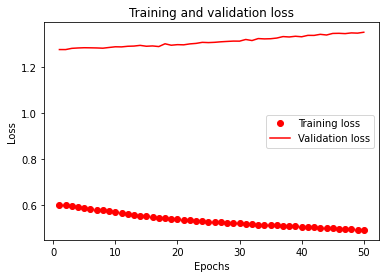

In [ ]:
# Loss, Accuracy 그래프 시각화 

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

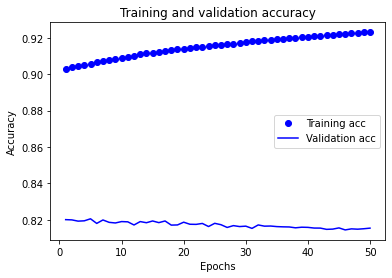

In [ ]:
plt.clf()   # 그림을 초기화합니다
# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Step 5. 모델 구현하기

- seq2seq는 교사 강요가 테스트 과정에서 동작이 다르다
- 그러므로 테스트 과정에서 모델을 다시 설계할 필요가있다.

In [ ]:
# 인코더 모델
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)

# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_units,))

# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_units,))

# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 디코더 출력층 재설계
decoder_outputs2  = decoder_softmax_layer(decoder_outputs2)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2 ] + decoder_states2)

In [ ]:
decoder_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, None, 64)     639360      ['input_18[0][0]']               
                                                                                                  
 input_21 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 64)]         0           []                               
                                                                                           

In [ ]:
# 단어 사전 준비하기
eng2idx = eng_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
fra2idx = fra_tokenizer.word_index
idx2fra = fra_tokenizer.index_word

In [ ]:
# decode_sequence() 구현

def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  states_value = encoder_model.predict(input_seq)
  
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = fra_tokenizer.word_index[sos_token]

  stop_condition = False
  decoded_sentence = ""

  # stop_condition이 True가 될 때까지 루프 반복
  while not stop_condition:
      # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
      output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

      # 예측 결과를 문자로 변환
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = fra_tokenizer.index_word[sampled_token_index]

      # 현재 시점의 예측 문자를 예측 문장에 추가
      decoded_sentence += sampled_char

      # <eos>에 도달하거나 최대 길이를 넘으면 중단.
      if (sampled_char == eos_token or
          len(decoded_sentence) > max_fra_seq_len):
          stop_condition = True

      # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
      target_seq = np.zeros((1, 1))
      target_seq[0, 0] =  sampled_token_index

      # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
      states_value = [h, c]

  return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + idx2eng[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != fra2idx['<sos>'] and encoded_word != fra2idx['<eos>']):
      sentence = sentence + idx2fra[encoded_word] + ' '
  return sentence

In [ ]:
# 출력 결과 테스트하기
import numpy as np

for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : hi . 
정답문장 : salut ! 
번역문장 : alut!
--------------------------------------------------
입력문장 : hello ! 
정답문장 : salut ! 
번역문장 : alut!
--------------------------------------------------
입력문장 : hop in . 
정답문장 : montez . 
번역문장 : renezleyeux.
--------------------------------------------------
입력문장 : help me ! 
정답문장 : aide-moi ! 
번역문장 : 
--------------------------------------------------
입력문장 : humor tom . 
정답문장 : mettez tom de bonne humeur . 
번역문장 : omauncoupd
--------------------------------------------------


In [ ]:
# 출력 결과 테스트하기
import numpy as np

for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print(35*'-')
  print('입력 문장:', lines_c.eng[seq_index])
  print('정답 문장:', lines_c.fra[seq_index][1:len(lines_c.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
  print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: ['hi', '.']
정답 문장: ['salut', '!']
번역기가 번역한 문장: salut!<eos
-----------------------------------
입력 문장: ['hello', '!']
정답 문장: ['salut', '!']
번역기가 번역한 문장: salut!<eos
-----------------------------------
입력 문장: ['hop', 'in', '.']
정답 문장: ['montez', '.']
번역기가 번역한 문장: prenezleyeux.<eos
-----------------------------------
입력 문장: ['help', 'me', '!']
정답 문장: ['aide-moi', '!']
번역기가 번역한 문장: ?<eos
-----------------------------------
입력 문장: ['humor', 'tom', '.']
정답 문장: ['mettez', 'tom', 'de', 'bonne', 'humeur', '.']
번역기가 번역한 문장: tomauncoupdepie


In [ ]:
# 출력 결과 테스트하기
import numpy as np

for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print(35*'-')
  print('입력 문장:', lines_c.eng[seq_index])
  print('정답 문장:', lines_c.fra[seq_index][1:len(lines_c.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
  print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: ['hi', '.']
정답 문장: ['salut', '!']
번역기가 번역한 문장: jeveuxbesoindej'ador
-----------------------------------
입력 문장: ['hello', '!']
정답 문장: ['salut', '!']
번역기가 번역한 문장: j'étaistoutàparle
-----------------------------------
입력 문장: ['hop', 'in', '.']
정답 문장: ['montez', '.']
번역기가 번역한 문장: j'étaistrèsoccup
-----------------------------------
입력 문장: ['help', 'me', '!']
정답 문장: ['aide-moi', '!']
번역기가 번역한 문장: jevaispayer.<eos
-----------------------------------
입력 문장: ['humor', 'tom', '.']
정답 문장: ['mettez', 'tom', 'de', 'bonne', 'humeur', '.']
번역기가 번역한 문장: tuasl'airdetravai
